In [2]:
import phylopandas as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

def import_sequences():
    new_seq = ph.read_fasta(
        'smaller_data/Coronaviridae_2019_new.fasta')  # covid-19
    new_info = pd.read_csv(
    'smaller_data/Coronaviridae_2019_new_information_table.txt', sep='\t')
# (These two datasets were downloaded from GISAID https://www.gisaid.org)

    # other coronaviruses
    old_seq = ph.read_fasta('smaller_data/Coronaviridae_old.fasta')
    old_info = pd.read_csv(
        'smaller_data/Coronaviridae_old_information_table.txt', sep='\t')
    # (These two datasets were downloaded from Virus-Host DB https://www.genome.jp/virushostdb/).

    new_seq['class'] = 1  # new coronavirus
    old_seq['class'] = 0  # old coronavirus
    allseq = pd.concat([new_seq, old_seq])

    return allseq


allseq_df = import_sequences()
allseq_df.head()

,id,sequence,description,label,uid,class
0,407214,aTTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,407214 BetaCoV/USA/WA1-A12/2020|EPI_ISL_407214,407214,7EPFHi1IhT,1
1,411950,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,411950 BetaCoV/Jiangsu/JS01/2020|EPI_ISL_411950,411950,UbZy9Sp0H0,1
2,411915,CAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGA...,411915 BetaCoV/Taiwan/CGMH-CGU-01/2020|EPI_ISL...,411915,UZJbpxwpdQ,1
3,408515,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,408515 BetaCoV/Wuhan/IVDC-HB-envF13-21/2020|EP...,408515,MYezNdb30j,1
4,406970,AAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCT...,406970 BetaCoV/Hangzhou/HZ-1/2020|EPI_ISL_406970,406970,Qik7NX3sDH,1


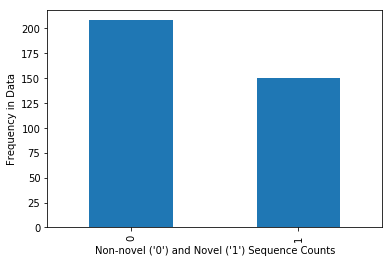

In [3]:
def plot_class_freq(df):
    plt.cla()
    plt.clf()
    # we will only need sequences to differentiate these viruses.
    ax = df['class'].value_counts().sort_index().plot.bar()
    ax.set_xlabel('Non-novel (\'0\') and Novel (\'1\') Sequence Counts')
    ax.set_ylabel('Frequency in Data')

plot_class_freq(allseq_df)

In [4]:
# Counting k-mers of a particular size
def get_Kmers_one_seq(seq, k):
    """gets all overlapping k-mers of a given sequence"""
    return [seq[x:x+k].lower() for x in range(len(seq) - k + 1)]


def get_Kmers_all_seqs(sequences, k):
    """get k-mers for a series of sequences"""
    kmers = np.zeros_like(sequences)
    for i, s in enumerate(sequences):
        kmers[i] = ' '.join(get_Kmers_one_seq(s, k))
    return list(kmers)

def get_kmers_df(X_df, k):
    """get a dataframe of k-mers associated with a sequence dataframe"""
    seq_kmers = get_Kmers_all_seqs(
        X_df['sequence'], k)  # k-mer "sentences" generated, one per sequence. Formatted as such to impute into sklearn count vectorizer.
    kmer_df = pd.DataFrame(seq_kmers)
    kmer_df.columns = ['kmers']
    return kmer_df

In [5]:
#Counting occurrences of each unique k-mer in sequence.

def get_kmer_counts(kmer_df, k):
    cv = CountVectorizer(ngram_range=(k, k))  # k,k
    kmer_counts = cv.fit_transform(
        kmer_df['kmers'].values.astype('U'))  # impute k-mers
    return kmer_counts  # returns a sparse matrix

def pca_kmer_counts(kmer_counts_mtx, n_components=2):
    """PCA step: reduce dimensionality of data to 2 by default.
    This means that only the top 2 most frequence k-mers are represented as 
    features for each sequence. Will use this to infer phylogeny"""
    X = kmer_counts_mtx.toarray()
    pca = PCA(n_components=n_components)
    pca.fit_transform(X)
    X_reduced = pca.fit_transform(X)
    return X_reduced

In [6]:
def generate_Xy(df,kmer_size):
    """taking in processed dataframe
    and creating X/y features/labels for
    clustering/classification purposes."""
    df['kmers'] = get_kmers_df(df, kmer_size)
    X = get_kmer_counts(df, kmer_size)
    y = list(df['class'].astype(int)) #ground-truth labels
    X_reduced = pca_kmer_counts(X,2)
    return X_reduced, y


In [7]:
def plot_true(X_reduced,y_true,kmer_size):
    plt.scatter(X_reduced[:,0],X_reduced[:,1], c = y_true, s = 200, cmap = 'prism', alpha = 0.20) #colored by label
    plt.title(f'PCA-reduced data, true labels, {kmer_size}-mers')
    plt.xlabel('PC1')
    plt.ylabel('PC2')



In [8]:
def k_means_elbow(data):
    df = pd.DataFrame(data)

    sse = {}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=100000).fit(df)
        df["curr_clusters"] = kmeans.labels_
        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()

In [9]:
def k_means_cluster(X_reduced,n_clusters):
    model = KMeans(n_clusters)
    y_pred = model.fit_predict(X_reduced)  # predict virus cluster
    centers = model.cluster_centers_
    return y_pred, centers

In [10]:
def plot_kmeans(X_reduced_all, y_pred, centers,K,kmer_size):
    plt.scatter(X_reduced_all[:, 0], X_reduced_all[:, 1],
                c=y_pred, s=50, cmap='prism', alpha =.20)  # colored by label
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=250, alpha=0.10)
    plt.title(f'K-means clustering, K={K} means, with K-mers of size {kmer_size}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

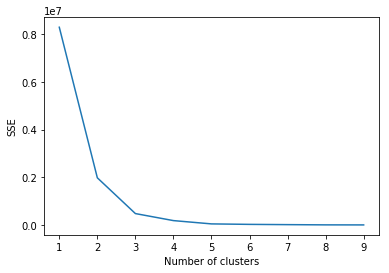

In [11]:
kmer_size = 5 #can range this later if desired.
X_reduced,y = generate_Xy(allseq_df,kmer_size)
k_means_elbow(X_reduced)

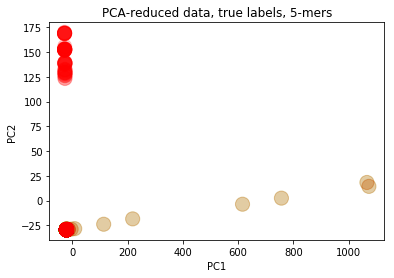

In [12]:
plot_true(X_reduced,allseq_df['class'],kmer_size)
#plotting, colored by ground-truth labels

In [13]:
y_pred_2means,centers_2means = k_means_cluster(X_reduced,2)
y_pred_3means,centers_3means = k_means_cluster(X_reduced,3)

The ARI for 5-mers, 2 clusters, versus ground-truth, is 0.0021063252822096814


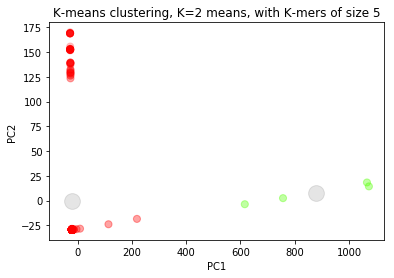

In [14]:
from sklearn.metrics import adjusted_rand_score

plot_kmeans(X_reduced, y_pred_2means, centers_2means,2,kmer_size)
print(f'The ARI for {kmer_size}-mers, 2 clusters, versus ground-truth, is', adjusted_rand_score(y_pred_2means,allseq_df['class']))


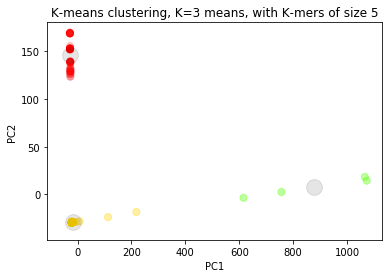

In [15]:
plot_kmeans(X_reduced, y_pred_3means, centers_3means,3,kmer_size)

# Increasing k-Mer Size to 10:


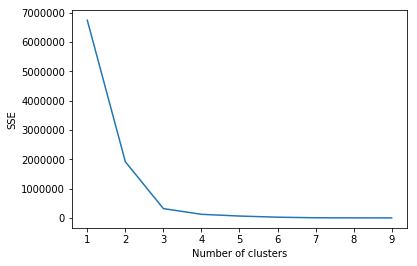

In [16]:
kmer_size = 10 #can range this later if desired.
X_reduced,y = generate_Xy(allseq_df,kmer_size)
k_means_elbow(X_reduced)

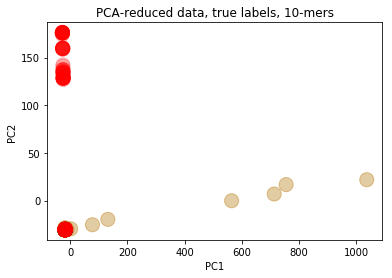

In [17]:
plot_true(X_reduced,allseq_df['class'],kmer_size)

In [18]:
y_pred_2means,centers_2means = k_means_cluster(X_reduced,2)
y_pred_3means,centers_3means = k_means_cluster(X_reduced,3)

The ARI for 10-mers, 2 clusters, versus ground-truth, is 0.0021063252822096814


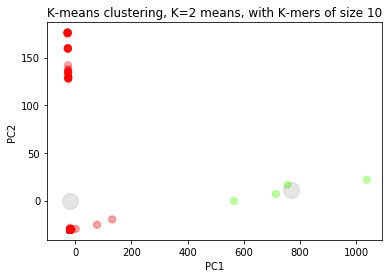

In [19]:
plot_kmeans(X_reduced, y_pred_2means, centers_2means,2,kmer_size)
print(f'The ARI for {kmer_size}-mers, 2 clusters, versus ground-truth, is', adjusted_rand_score(y_pred_2means,allseq_df['class']))

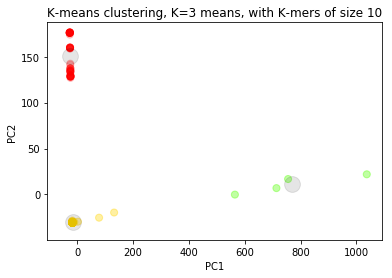

In [20]:
plot_kmeans(X_reduced, y_pred_3means, centers_3means,3,kmer_size)

# Increasing k-Mer Size to 100:

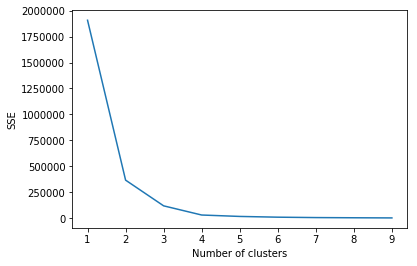

In [21]:
kmer_size = 100
X_reduced,y = generate_Xy(allseq_df,kmer_size)
k_means_elbow(X_reduced)

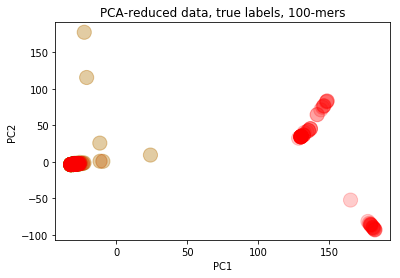

In [22]:
plot_true(X_reduced,allseq_df['class'],kmer_size)

In [23]:
y_pred_2means,centers_2means = k_means_cluster(X_reduced,2)
y_pred_3means,centers_3means = k_means_cluster(X_reduced,3)

The ARI for 100-mers, 2 clusters, versus ground-truth, is 0.012947109245300025


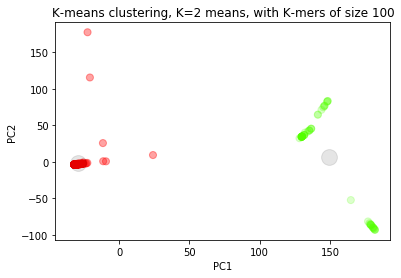

In [24]:
plot_kmeans(X_reduced, y_pred_2means, centers_2means,2,kmer_size)
print(f'The ARI for {kmer_size}-mers, 2 clusters, versus ground-truth, is', adjusted_rand_score(y_pred_2means,allseq_df['class']))


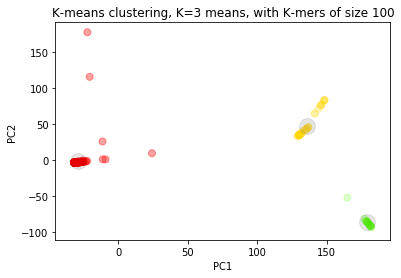

In [25]:
plot_kmeans(X_reduced, y_pred_3means, centers_3means,3,kmer_size)

# Conclusions

- Significant cluster overlap in all cases, suggesting strong phylogenetic concordance between old and new coronaviruses. Future considerations could involve classification of novel sequences based upon most k-mer-counted similar regions of genome
- This is a potential alternative take on genomic similarity for unknown sequences, which is typically the domain of classical bioinformatics algorithms, such as multiple sequence alignment.